# Global Terrorism DataSet Analysis: 

Data:
    - Where from?
    - Items
    - Scope
    - Contributors

Goals:
    - ...


In [155]:
import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.collections as mcol
#use this style of plots
plt.style.use('ggplot') 
#print plots in notebook
%matplotlib inline 

import sklearn as sk
from sklearn.cluster import *
from sklearn.preprocessing import OneHotEncoder

In [156]:
def convert_eventid_to_datetime(df, ignore_bad_data=True):
    """Converts dataframe with event_id column to date time formats. Returns new DF with additional 'datetime' column."""
    from datetime import datetime
    
    datetime_series = []
    ix_to_drop = []
    count = 0
    for i, row in df.iterrows():
        try:
            year = int(row['iyear'])
            month = int(row['imonth'])
            day = int(row['iday'])
            datetime_series.append( datetime(year, month, day) )
        except:
            ix_to_drop.append(count)
            if not ignore_bad_data:
                print("Bad Event ID date format: {}, {}, {}. Event ID: {}"
                      .format(year, month, day, row['eventid']) )
                raise ValueError('Event Id data contains bad dates.')
        count += 1
        
    print('Dropped {} malformed event id rows out of {}.'.format(len(ix_to_drop), df.shape[0]))
    df = df.drop(df.index[ix_to_drop])
    df['datetime'] = pd.to_datetime(datetime_series)
    
    return df

## Read in and sub-sample data

1. Read in dataframe, specifying subset of columns
2. Optionally sub-sample data to manageable size

In [192]:
#read in the data file and make into a pandas dataframe: location, only specific columns
original_df = pd.read_csv('./inputs/globalterrorismdb.csv', encoding='ISO-8859-1', usecols=['eventid', 'iyear', 'imonth', 'iday', 'country', 'region', 
                         'latitude', 'longitude', 'crit1', 'crit2', 'crit3', 'attacktype1','targtype1','targsubtype1','weaptype1',
                          'weapsubtype1'],
                         dtype={'iyear':'int', 'imonth':'int', 'iday':'int'});

#use a manageable sample size
num_rows = 10000
#shows the size of the original data
# print('Original shape of CSV: {}'.format(original_df.shape))

# DropNA() is dropping all NaN values from the dataset. Talk about potential bias. Investigate what causes this bad data.
#Free up memory by deleting the unused origial data
terrorism_df = original_df.dropna().sample(n=num_rows)
del original_df
print(type(terrorism_df))

#displays the columns being used
print(terrorism_df.columns)

# Convert known event times to timestamp column
datetime_df = convert_eventid_to_datetime(terrorism_df, ignore_bad_data=True)    
print(datetime_df.shape)

terrorism_df = datetime_df
del datetime_df


<class 'pandas.core.frame.DataFrame'>
Index(['eventid', 'iyear', 'imonth', 'iday', 'country', 'region', 'latitude',
       'longitude', 'crit1', 'crit2', 'crit3', 'attacktype1', 'targtype1',
       'targsubtype1', 'weaptype1', 'weapsubtype1'],
      dtype='object')
Dropped 38 malformed event id rows out of 10000.
(9962, 17)


## Scatter Plots 
Can see how some of the data may be realted based on scatter plots generated:
    1. Latitude vs Longitude shows us the location of attacks. 
        *Could underlay a map to get a better visual if wanted.    

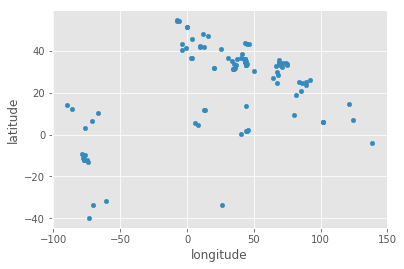

In [193]:
# terrorism_df['iyear']
#print(terrorism_df.shape)
# print(terrorism_df.columns)

year_lat_df = terrorism_df[0:100][['latitude', 'longitude']]

year_lat_df.plot.scatter(x='longitude',y='latitude')

### Testing clustering on Latitude and Longitude
      1. Use K-means algorthim to cluster points to two groups based on "closeness"
      2. Use colormap to view the different clusters

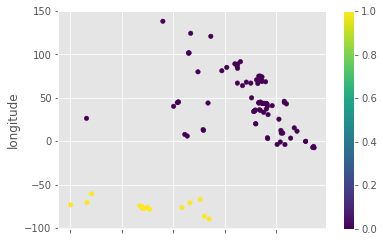

In [194]:
from sklearn.cluster import KMeans

cl = sk.cluster.KMeans(n_clusters=2).fit(year_lat_df)

year_lat_df.plot.scatter(x='latitude',y='longitude', c=cl.labels_, colormap='viridis')

### One hot encoding

One hot encoding deals with our categorical variables by creating an <em>n-dimensional</em> row vector per category.

* Specify columns
* Get dummy variables
    * Optionally append to previous dataframe

In [195]:
#create new data frame with the dummy variables included
t_dummies_df = pd.get_dummies(terrorism_df, columns=['weaptype1', 'region'], dtype=bool)


### Pair Plots

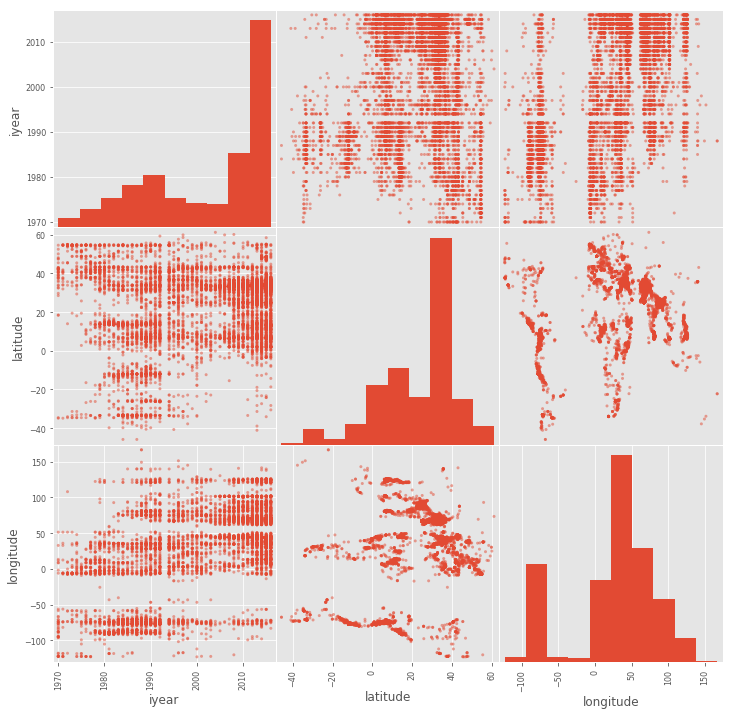

In [196]:
#Plots each variable with each other and displays a matrix of different plots
scatter_matrix(terrorism_df[['iyear', 'latitude', 'longitude']], figsize=(12, 12))
plt.show()

# Data Exploration
    Questions:
        1. Is there a certain time during the year that attacks are more frequent?
    

### Subsection 1: Time of Year

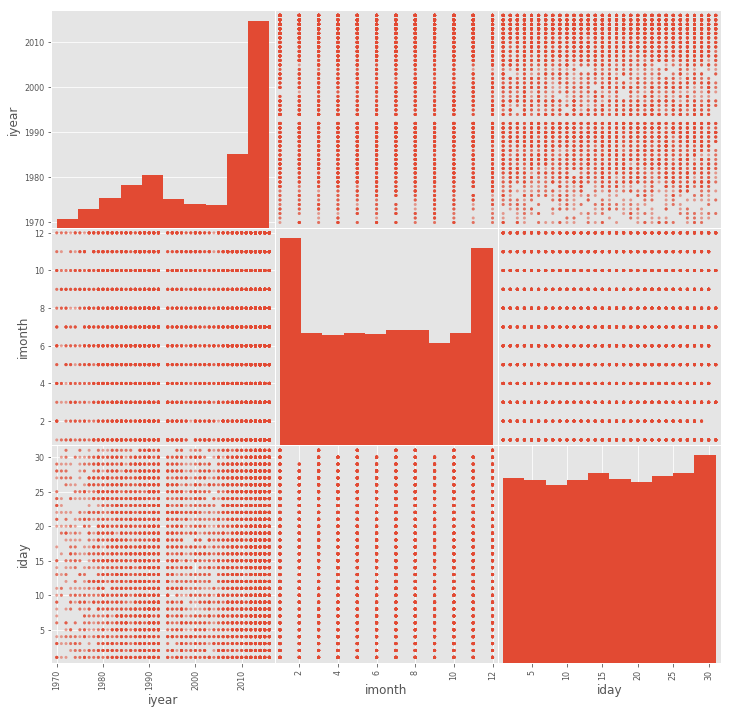

In [200]:
#View plot of months over years to see if any common/uncommon attack months
scatter_matrix(terrorism_df[['iyear', 'imonth', 'iday']], figsize=(12, 12))
plt.show()

#Create a encoding that makes true/false columns for each month
#months_region_dummies_df = pd.get_dummies(terrorism_df, columns=['region'], dtype=bool)


################################################################################################
#Looking into Region 10 2016 attacks:

#make a new dataframe based on region 10:
#region_10_df = months_region_dummies_df[(months_region_dummies_df['region_10'] == 1)]
#terrorism_df['region_10'] = months_region_dummies_df['region_10']
# scatter_matrix(region_10_df[['iyear', 'imonth', 'iday']], figsize=(12, 12))
# plt.show()
# region_10_df_june = region_10_df[(region_10_df['imonth'] == 6)]
# region_10_df_j2016 = region_10_df_june[(region_10_df_june['iyear']==2016)]

#scatter_matrix(region_10_df[['iyear', 'iday', 'imonth']], figsize=(12, 12))
#plt.show()

# region_10_df_j2016.iloc[0:]
###############################################################################################



#### Line plot of Global Monthly Trend


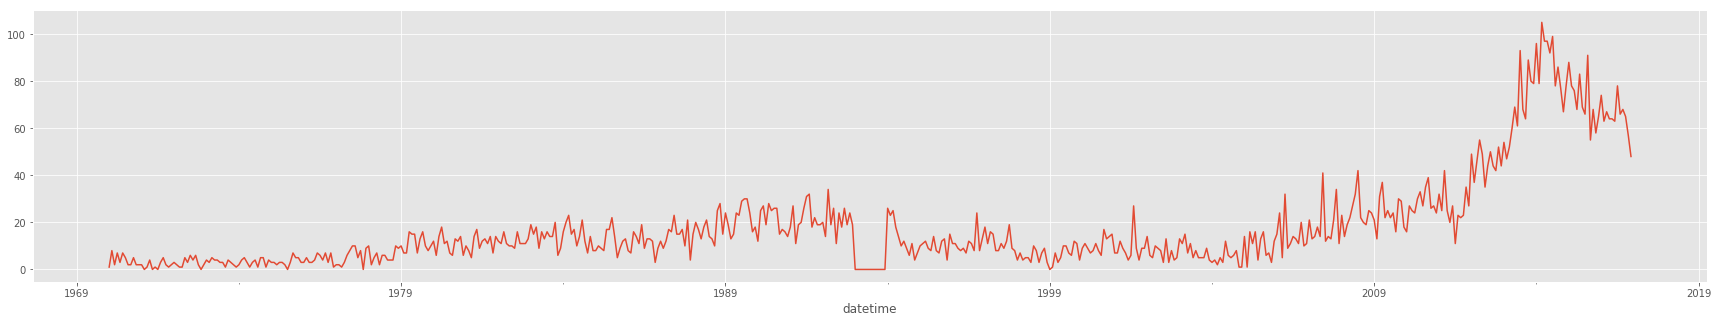

In [224]:
# Line plot of events over time
# grouped_terr_df = terrorism_df.groupby(['datetime']).count()

datetime_df = terrorism_df.set_index('datetime')

start_date = '1970-01-1'
end_date = '2017-01-01'

# daily_terr_df = datetime_df[start_date:end_date].groupby(pd.Grouper(freq='D')).count()
monthly_terr_df = datetime_df[start_date:end_date].groupby(pd.Grouper(freq='M')).count()

#daily_terr_df['eventid'].plot(kind='line', figsize=[30,5])
monthly_terr_df['eventid'].plot(kind='line', figsize=[30,5])

#monthly_terr_df.plot(kind='line', figsize=[30,5])

#####################################################################################################
# ADDED COLUMN FOR REGION 10 SUM FOR EASY PLOTTING
# monthly_terr_df['region_10_sum'] = datetime_df[start_date:end_date].groupby(pd.Grouper(freq='M'))['region_10'].sum()
# monthly_terr_r_10_df = [start_date:end_date].groupby(pd.Grouper(freq='M')).count()
# monthly_terr_df['region_10_sum'].plot(kind='line', figsize=[25,10])
# monthly_terr_df.iloc[0:20]

# region_10_df.plot(kind='line', figsize=[30,5])
# plt.savefig('./terr_event_date.png')
# region_10_df / monthly_terr_df['']
# ratio = region_10_df[''] / monthly_terr_df
# monthly_terr_df.plot(x=monthly_terr_df.index, y='region_10_sum', kind='line', figsize=[25,5])
#######################################################################################################

### Yearly Monthly Trend
    Our graph above shows a possible global monthly trend for attack occurances. Next we will explore if there is a yearly
    trend as well. 


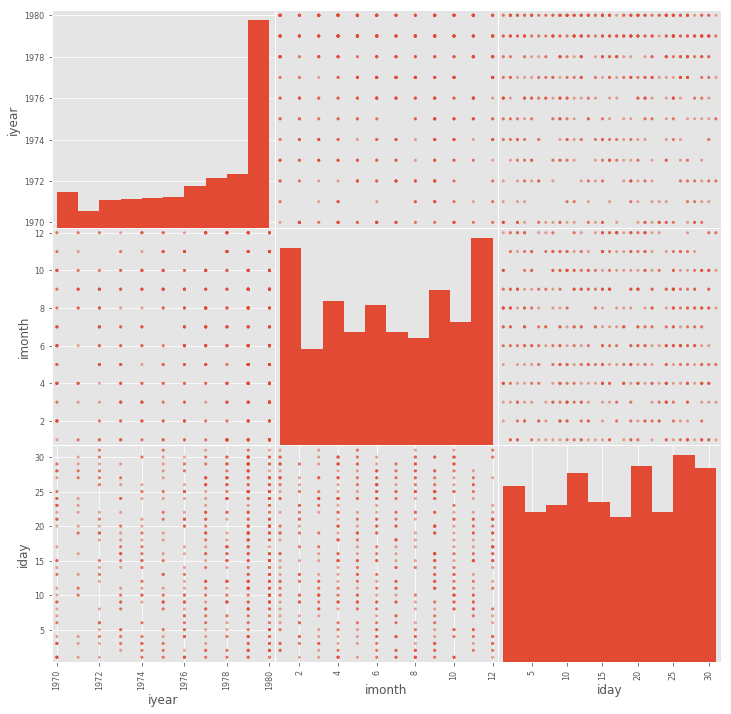

In [222]:
#slice data frame into 5 year intervals
seventyFive_terrorism_df = terrorism_df[(terrorism_df['iyear'] <= 1980)]
#seventyFive_terrorism_df.iloc[0:]
scatter_matrix(seventyFive_terrorism_df[['iyear', 'imonth', 'iday']], figsize=(12, 12))
plt.show()


# start_date = '1970-01-1'
# end_date = '1973-01-01'

# # daily_terr_df = datetime_df[start_date:end_date].groupby(pd.Grouper(freq='D')).count()
# monthly_terr_df = datetime_df[start_date:end_date].groupby(pd.Grouper(freq='M')).count()

# #daily_terr_df['eventid'].plot(kind='line', figsize=[30,5])
# monthly_terr_df['eventid'].plot(kind='line', figsize=[30,5])